# Training demo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Before training the model, we should first import some necessary dependencies

In [5]:
import os,sys
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import math
from tqdm import tqdm

According to the torchvision documentation：
[torchvision documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.maskrcnn_resnet50_fpn)

During training, the model expects both the input image tensors and targets (list of dictionary), containing:

boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the class label for each ground-truth box

masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each instance

## Define dataset

So

In the "init" function:

We creates two lists: "imgs" and "anns". "imgs" contains the names of all image files in the "images_train" directory, and "anns" contains the names of all annotation files in the "annotations_train" directory. These lists are sorted in alphabetical order to ensure that each image and its corresponding annotation are matched correctly.

In the "getitem" function:

We load the image and annotation data by the index of the sorted list, and then convert the image and annotation to the tensor type required by the model, the annotation tensors are combined into a dictionary named "target", finally, the function returns a tuple containing the loaded image tensor and the "target" dictionary which is the required input format for the model.

If your data size is small, you can also do some random data augmentation during training by adding a transform function in the getitem method.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_set='images_train', annotation_set='masks_train'):
        self.root = root
        self.image_set = image_set
        self.annotation_set = annotation_set

        # Load all image and annotation files and make sure they are sorted
        self.imgs = list(sorted(os.listdir(os.path.join(root, image_set))))
        self.anns = list(sorted(os.listdir(os.path.join(root, annotation_set))))

    def __getitem__(self, idx):

        # Load images and annotations
        img_path = os.path.join(self.root, self.image_set, self.imgs[idx])
        ann_path = os.path.join(self.root, self.annotation_set, self.anns[idx])
        img = Image.open(img_path)
        ann = np.load(ann_path, allow_pickle='TRUE').item()

        # Convert annotation into torch Tensor
        boxes = torch.as_tensor(ann['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(ann['labels'], dtype=torch.int64)
        masks = torch.as_tensor(ann['masks'], dtype=torch.uint8)

        # Convert image into torch Tensor
        convert_tensor = transforms.ToTensor()
        img = convert_tensor(img)

        # Put annotations into 'target' which torchvision.models.detection.maskrcnn_resnet50_fpn required
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks

        # Return required inputs of model which are input tensor and target
        return img, target

    def __len__(self):
        return len(self.imgs)

## Define collate function

In this section, we define the collation functions for the data loader, since the default functions are not suitable for our data format.

In [ ]:
# Define dataloader's collate function
def my_collate_fn(batch):
    return tuple(zip(*batch))

## Load the data

Next, we load data from CustomDataset class and split it into train and valid sets, then load both datasets into dataloaders.

Due to the limitation of Vram, we set the batch size to 1 in this demo, if you have a GPU with larger Vram, you can try to increase the batch size, and try to use multiple num_workers.

The recommended batch size is Vram size/6.

In [ ]:
# Split dataset into train dataset and valid dataset
dataset = CustomDataset('dataset')
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(0))

# Load datasets to dataloaders
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=my_collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, collate_fn=my_collate_fn)

## Define model architecture

If we want to fine-tune Mask-RCNN on a custom dataset, we need to modify the model's pre-trained head to fit our data classes.

The architecture of the Mask-RCNN model has a classifier (box_predictor) and a mask classifier (mask_predictor), both of which should be adapted to our data classes. So we need to modify both pretrained heads with a new one.

In [ ]:
def build_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

## Initialize model and optimizer

After defining the model architecture, we can now build the model with custom classes number and move the model to the GPU.

(cpu can also do training, but it will be extremely slow)

The default optimizer we're using here is SGD with a default learning rate of 0.0001, but of course you can tweak it as much as you want to make the model fit your data better.

The default learning rate is fixed during training, but you can also use lr_scheduler to change your learning rate during training

In [ ]:
# Set caculating deivce
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"training device is {device}")

# Set classes number (should include background here)
num_classes = 2

# Get the model using our helper function
model = build_model(num_classes)

# Move model to device
model.to(device)

# Construct an optimizer
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model_parameters, lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Set a learning rate scheduler (defualt value is a constant learning rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

training device is cuda


## Define training process

In the training function, we create a dictionary to store the losses for each training iteration. The losses including:

classifier loss,box regression loss, mask loss, objectness loss, RPN box regression loss,and the sum of these individual losses.

If the current epoch is the first epoch, a learning rate scheduler is set up to perform warm-up learning, where the learning rate is gradually increased from a very small value to the actual learning rate specified in the optimizer.

We also use the tqdm library to display our training progress

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    lr_scheduler = None

    # Build a dictionary to recored losses
    LOSS = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[]
    }

    # Warm up the model in the first epoch
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Training process
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        for i in loss_dict.keys():
            LOSS[i].append(loss_dict[i].item())
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        LOSS['loss_sum'].append(loss_value)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    return LOSS

## Define validating process

Just like the training function, we also create a dictionary to store the losses for each validating iteration in validating function.

To speed up our validation process, we use torch.no_grad() to make the model evaluate without computing gradients.

In [ ]:
def val_one_epoch(model, data_loader, device, epoch):
    # Build a dictionary to recored losses
    LOSS = {
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }

    # Speed up evaluation by not computing gradients
    with torch.no_grad():
        model.train()

        # Evaluating process
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            for i in loss_dict.keys():
                LOSS["val_"+i].append(loss_dict[i].item())
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            LOSS['val_loss_sum'].append(loss_value)

    return LOSS

## Set up some names, logging tool and epoch numbers

Before training our model, we should set our model name and build a logging tool, and set the number of epochs

In [ ]:
# Name the model
model_name = "my_model"

# Build a dictionary to recored losses
LOSSES = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[],
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }

# Declare the checkpoint saving paths
PATH = 'checkpoints/' + model_name + '_checkpoint.pt'
min_PATH = 'checkpoints/' + model_name + '_checkpoint_min.pt'

# Declare a minimum loss value to ensure whether the current epoch has the minimum loss
min_loss = None

# Set the training epochs number
num_epochs = 10

## Start training

Finally, we can start training our custom mask-rcnn model. You can monitor the training progress of each epoch through the progress bar.

After each epoch is trained, There will be a loss curve chart showing the current loss curve for every types of losses. This chart will also be saved in the current directory.

The program will automatically save the checkpoints of the model after every 5 epochs, and save the checkpoints with the smallest verification loss during training. You can also modify the code to adjust the frequency of saving checkpoints.

After training, the model will be saved. If you want to use the checkpoint with the smallest validation loss as the final model, you can additionally load the checkpoint and save it.

epoch 0 is training - learning rate = 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:33<00:00,  2.42it/s]


epoch 0 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.46it/s]


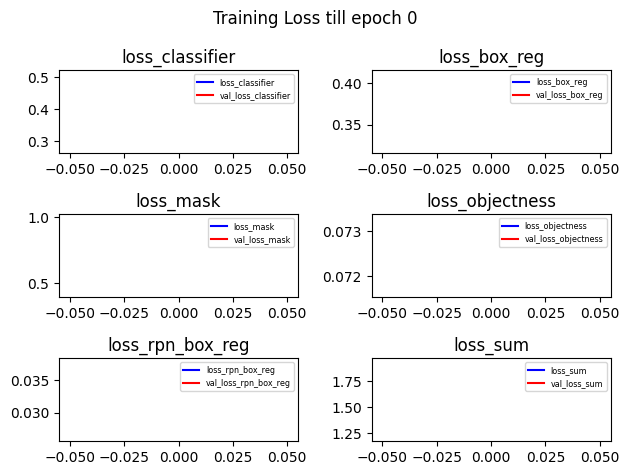

train loss sum = 1.930171935260296
valid loss sum = 1.2043450206518174

epoch 1 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.59it/s]


epoch 1 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.53it/s]


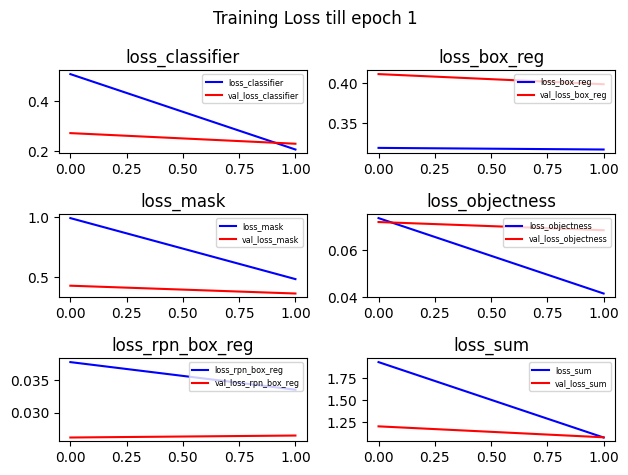

train loss sum = 1.0783904798328876
valid loss sum = 1.0807359233498572

epoch 2 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.58it/s]


epoch 2 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.56it/s]


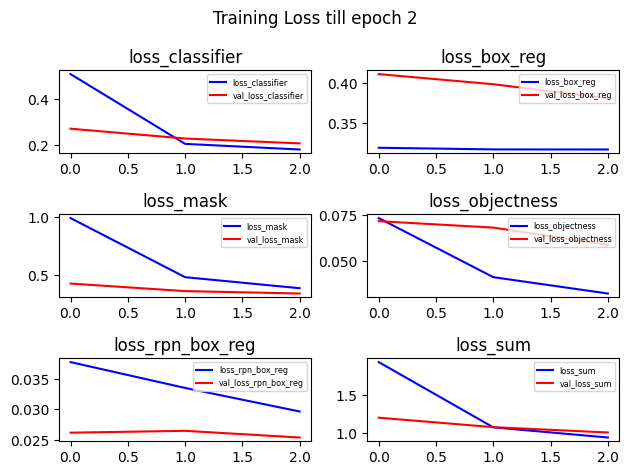

train loss sum = 0.9456200525164604
valid loss sum = 1.01126609146595

epoch 3 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.54it/s]


epoch 3 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]


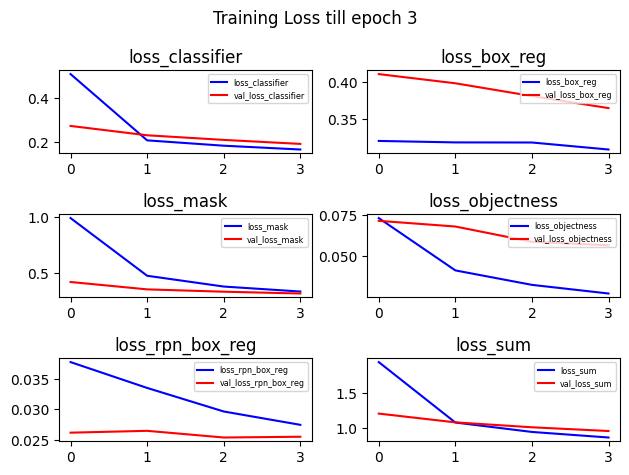

train loss sum = 0.8671616107225418
valid loss sum = 0.9587185829877853

epoch 4 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.55it/s]


epoch 4 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]


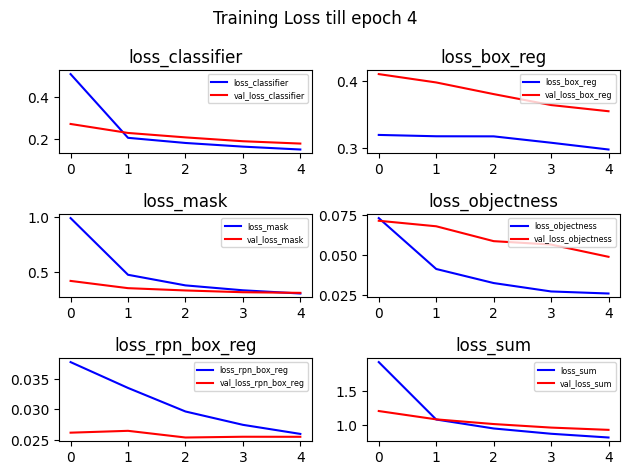

train loss sum = 0.811603982001543
valid loss sum = 0.9250903427600861

epoch 5 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.54it/s]


epoch 5 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.36it/s]


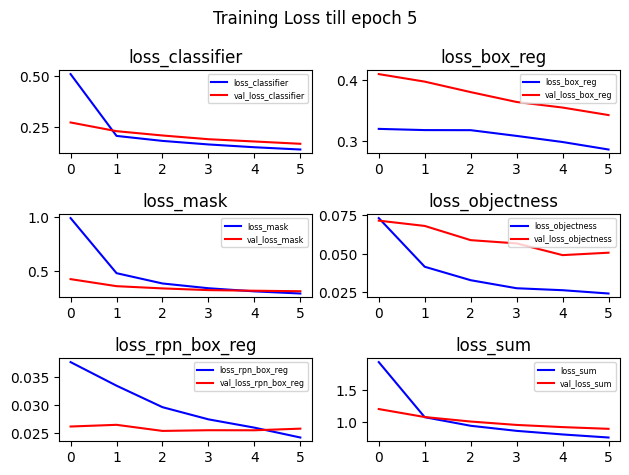

train loss sum = 0.7643188025802374
valid loss sum = 0.8985616520047188

epoch 6 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.55it/s]


epoch 6 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]


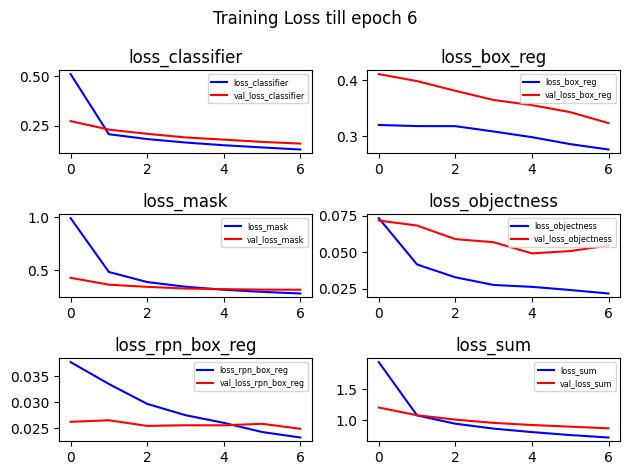

train loss sum = 0.7252006936818362
valid loss sum = 0.8718861415982246

epoch 7 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.53it/s]


epoch 7 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.19it/s]


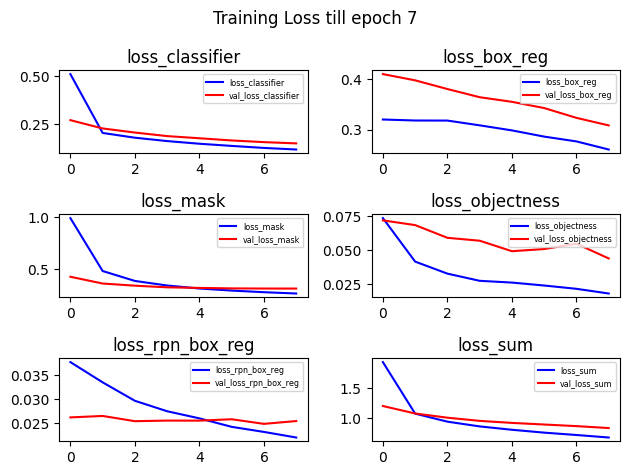

train loss sum = 0.6837752809748053
valid loss sum = 0.8399516299366951

epoch 8 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.50it/s]


epoch 8 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.60it/s]


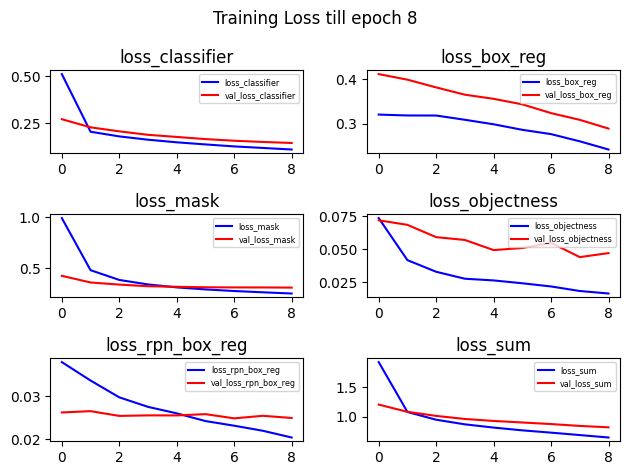

train loss sum = 0.6420795764774084
valid loss sum = 0.8161452367901803

epoch 9 is training - learning rate = 9.999999999999998e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.56it/s]


epoch 9 is validating


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]


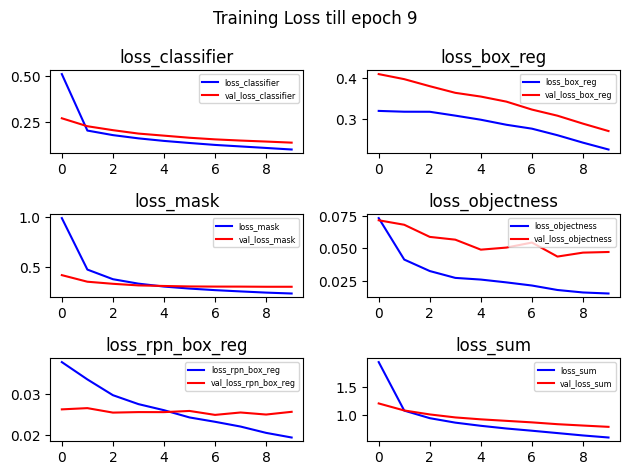

train loss sum = 0.6060541158542037
valid loss sum = 0.7932166948914527



In [ ]:
# Training process
for epoch in range(num_epochs):
        print(f"epoch {epoch} is training - learning rate = {lr_scheduler.get_last_lr()[0]}")
        # Train for one epoch and recored train losses
        LOSSES_train = train_one_epoch(model, optimizer, data_loader_train, device, epoch)

        # Update the learning rate
        lr_scheduler.step()

        print(f"epoch {epoch} is validating")
        # valid for one epoch and recored valid losses
        LOSSES_val = val_one_epoch(model, data_loader_val, device, epoch)

        # Draw and save the loss curve
        plt.figure(epoch)
        plt.suptitle(f"Training Loss till epoch {epoch}")

        for i, v in enumerate(LOSSES_train.keys()):
            LOSSES[v].append(sum(LOSSES_train[v])/len(LOSSES_train[v]))
            plt.subplot(3, 2, i+1)
            plt.plot(LOSSES[v], label=v, color='b')
            plt.title(v)

        for i, v in enumerate(LOSSES_val.keys()):
            LOSSES[v].append(sum(LOSSES_val[v])/len(LOSSES_val[v]))
            plt.subplot(3, 2, i+1)
            plt.plot(LOSSES[v], label=v, color='r')
            plt.legend(fontsize='xx-small', loc='upper right')

        plt.tight_layout()
        plt.savefig('losses_curves/' + model_name + "_losses_curve.png", dpi=600)
        plt.show()

        # Print out current train loss and valid loss
        print(f"train loss sum = {sum(LOSSES_train['loss_sum'])/len(LOSSES_train['loss_sum'])}")
        print(f"valid loss sum = {sum(LOSSES_val['val_loss_sum'])/len(LOSSES_val['val_loss_sum'])}\n")

        # If the loss for the current epoch is minimal, save it to the checkpoint
        if not min_loss or LOSSES['val_loss_sum'][-1] < min_loss:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': LOSSES,
                    }, min_PATH)
            min_loss = LOSSES['val_loss_sum'][-1]

        # Save training datas to the checkpoint every 5 epoch
        if (epoch+1)%5 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': LOSSES,
                    }, PATH)

# Save the final model
torch.save(model, 'models/' + model_name + '.pt')

## Simple evaluation

After training, we now have a custom model, we can try to do some simple evaluation through the model.

Of course, we need to import some dependencies first and define some functions for prediction and postprocessing.

In [ ]:
import cv2
import random

In [ ]:
def get_colors():
    colors = []
    for i in range(0,255,120):
        for j in range(0,255,120):
            for k in range(0,255,120):
                colors.append((i,j,k))
    colors.pop(0)
    random.shuffle(colors)
    return colors

In [ ]:
def colorize(mask,color):
    color_mask = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    color_mask[mask > 0] = color
    return color_mask

In [ ]:
def predict(img, model, class_name, threshold=0.5):
    img_tensor = transforms.ToTensor()(img).to(device,torch.float)
    result = model([img_tensor])
    scores = list(result[0]['scores'].cpu().detach().numpy())
    valid_num = sum(map(lambda x : x > threshold, scores))
    masks = (result[0]['masks']>0.5).squeeze().cpu().detach().numpy()[:valid_num]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(result[0]['boxes'].detach().cpu().numpy().astype(int))][:valid_num]
    classes = [class_name[i] for i in list(result[0]['labels'].cpu().numpy())][:valid_num]
    return masks, boxes, classes

In [ ]:
def post_processing(img, colors, masks, boxes, classes):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        color = colors[i%len(colors)]
        color_mask = colorize(masks[i],color)
        img = cv2.addWeighted(img, 1, color_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color, 2)
        x,y = boxes[i][0]
        cv2.putText(img, classes[i], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return img

In [ ]:
def plot_result(img_path, model, class_name):
    img = cv2.imread(img_path)
    masks, boxes, classes = predict(img, model, class_name)
    result = post_processing(img, get_colors(), masks, boxes, classes)
    plt.figure(1)
    plt.imshow(result)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Now, we can define our custom classes and plot the result.

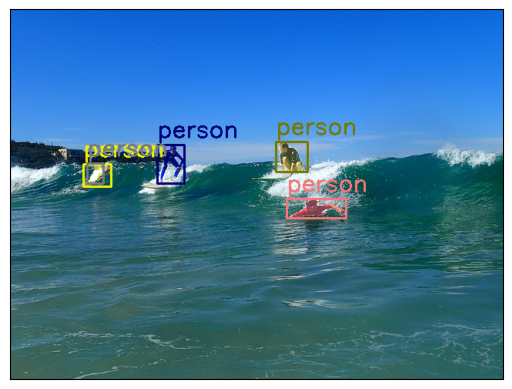

In [ ]:
model.eval()
class_name = ['__backgrounf__','person']
plot_result(img_path='test.jpg', model=model, class_name=class_name)